In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from affine import *

In [2]:
# simulate data (lognormal population prior + gaussian noise)

# set-up
mu_ = 1.0
logsigma_ = tf.math.log(0.5)
logsigma_noise_ = tf.math.log(1.0)
n_latent = 1000

# simulate
logx_ = tf.random.normal([n_latent, 1], mu_, tf.exp(logsigma_)) # latent parameters ~ lognormal
x_ = tf.exp(logx_)
y_ = x_ + tf.random.normal([n_latent, 1], 0., tf.exp(logsigma_noise_)) # add gaussian noise to observations

In [3]:
# create walkers...

n_hyper_walkers = 100
n_latent_walkers = 100

# initialize latent parameter walkers
latent_init_mean = logx_
latent_init_sigma = 0.1
latent_walkers_1 = latent_init_mean + tf.random.normal([n_latent_walkers] + latent_init_mean.shape, 0., latent_init_sigma)
latent_walkers_2 = latent_init_mean + tf.random.normal([n_latent_walkers] + latent_init_mean.shape, 0., latent_init_sigma)

# initialize hyperparameter walkers
hyper_init_mean = tf.concat([mu_, logsigma_], axis=0)
hyper_init_sigma = 0.1
hyper_walkers_1 = hyper_init_mean + tf.random.normal([n_hyper_walkers] + hyper_init_mean.shape, 0., hyper_init_sigma)
hyper_walkers_2 = hyper_init_mean + tf.random.normal([n_hyper_walkers] + hyper_init_mean.shape, 0., hyper_init_sigma)

# set current states (REMEMBER: two sets, so that affine stretch moves can be parallelized)
latent_current_state = [latent_walkers_1, latent_walkers_2]
hyper_current_state = [hyper_walkers_1, hyper_walkers_2]

# create conditional densities
def log_hyperparameter_conditional(hyperparameters, latentparameters):
    
    # split hyper-parameters
    mu, logsigma = tf.split(hyperparameters, (1,1), axis=-1)
    
    # log latent parameters
    logx = latentparameters
    
    # log pdf
    #return tf.stack([tf.reduce_sum(-0.5 * tf.square(tf.divide(tf.subtract(mu[_,:], logx), tf.exp(logsigma[_,:]) )) - logsigma[_,:]) for _ in range(mu.shape[0])], axis=0)
    return tf.reduce_sum(tf.reduce_sum(-0.5 * tf.square(tf.divide(tf.subtract(tf.expand_dims(mu, axis=1), logx), tf.exp(tf.expand_dims(logsigma, axis=1)) )) - tf.expand_dims(logsigma, axis=1), axis=-1), axis=-1)

def log_latentparameter_conditional(latentparameters, hyperparameters, data):
    
    # split hyper-parameters
    mu, logsigma = tf.split(hyperparameters, (1,1), axis=-1)
    
    # log latent parameters
    logx = latentparameters
    x = tf.exp(latentparameters)
    
    # log pdf
    logprior = tf.squeeze(-0.5 * tf.square(tf.divide(tf.subtract(mu, logx), tf.exp(logsigma) )) - logsigma)
    loglikelihood = tf.squeeze(-0.5 * tf.square(tf.divide(tf.subtract(data, x), tf.exp(logsigma_noise_) )) - logsigma_noise_)
    
    return logprior + loglikelihood

In [6]:
n_steps = 100
n_sub_steps = 10

hyper_chain = []
latent_chain = []

with trange(n_steps) as t:
    for step in t:
    
        # sample hyper-parameter conditional
        hyper_samples_ = affine_sample(log_hyperparameter_conditional, n_sub_steps, hyper_current_state, args=[latent_current_state[np.random.randint(0, 2)][np.random.randint(0, n_latent_walkers),...]], progressbar=False)
        hyper_current_state = tf.split(hyper_samples_[-1,...], (n_hyper_walkers, n_hyper_walkers), axis=0)

        # sample the latent parameter conditional
        latent_samples_ = affine_sample_batch(log_latentparameter_conditional, n_sub_steps, latent_current_state, args=[hyper_current_state[np.random.randint(0, 2)][np.random.randint(0, n_hyper_walkers),...], y_], progressbar=False)
        latent_current_state = tf.split(latent_samples_[-1,...], (n_hyper_walkers, n_hyper_walkers), axis=0)
        
        # collect samples
        hyper_chain.append(tf.concat(hyper_current_state, axis=0))
        latent_chain.append(tf.concat(latent_current_state, axis=0))
        
# stack chains
hyper_chain = tf.stack(hyper_chain, axis=0)
latent_chain = tf.stack(latent_chain, axis=0)

100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


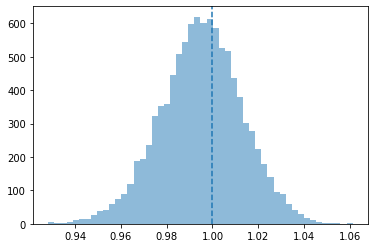

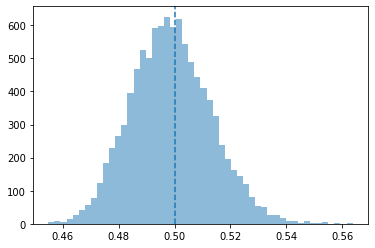

In [7]:
plt.hist(hyper_chain[50:,:,0].numpy().flatten(), bins = 50, alpha = 0.5)
plt.axvline(mu_, ls = '--')
plt.show()

plt.hist(np.exp(hyper_chain[50:,:,1].numpy().flatten()), bins = 50, alpha = 0.5)
plt.axvline(np.exp(logsigma_), ls = '--')
plt.show()

Same as above but batched over latent variables

In [9]:
n_steps = 100
n_sub_steps = 10

hyper_chain = []
latent_chain = []

# set up batching of latent parameters
latent_batch_size = 64
n_latent_batches = n_latent // latent_batch_size + int( (n_latent % latent_batch_size) > 0)
batch_indices = [np.arange(latent_batch_size*i, min(latent_batch_size*(i+1), n_latent)) for i in range(n_latent_batches)]

# main loop
with trange(n_steps) as t:
    for step in t:
    
        # sample hyper-parameters, conditioned on latent parameters
        hyper_samples_ = affine_sample(log_hyperparameter_conditional, n_sub_steps, hyper_current_state, args=[latent_current_state[np.random.randint(0, 2)][np.random.randint(0, n_latent_walkers),...]], progressbar=False)
        hyper_current_state = tf.split(hyper_samples_[-1,...], (n_hyper_walkers, n_hyper_walkers), axis=0)

        # sample latent parameters, conditioned on hyper-parameters (do it in batches and concatenate them together)
        latent_samples_ = tf.concat([affine_sample_batch(log_latentparameter_conditional, 
                                                         n_sub_steps, 
                                                         [tf.gather(latent_current_state[0], batch_indices[_], axis=1), tf.gather(latent_current_state[1], batch_indices[_], axis=1)], 
                                                         args=[hyper_current_state[np.random.randint(0, 2)][np.random.randint(0, n_hyper_walkers),...], tf.gather(y_, batch_indices[_], axis=0)],
                                                         progressbar=False) for _ in range(n_latent_batches)], axis=2)
        latent_current_state = tf.split(latent_samples_[-1,...], (n_hyper_walkers, n_hyper_walkers), axis=0)
        
        # append samples to the chains
        hyper_chain.append(tf.concat(hyper_current_state, axis=0))
        latent_chain.append(tf.concat(latent_current_state, axis=0))
        
# stack the chains
hyper_chain = tf.stack(hyper_chain, axis=0)
latent_chain = tf.stack(latent_chain, axis=0)

100%|██████████| 100/100 [01:00<00:00,  1.65it/s]


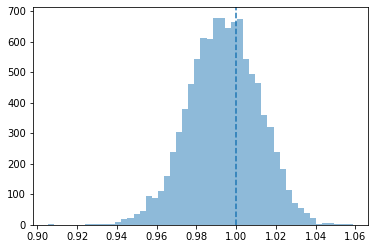

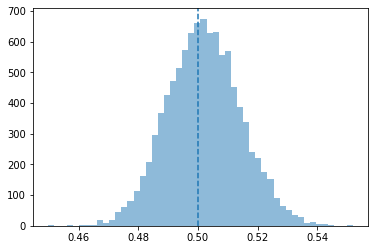

In [10]:
plt.hist(hyper_chain[50:,:,0].numpy().flatten(), bins = 50, alpha = 0.5)
plt.axvline(mu_, ls = '--')
plt.show()

plt.hist(np.exp(hyper_chain[50:,:,1].numpy().flatten()), bins = 50, alpha = 0.5)
plt.axvline(np.exp(logsigma_), ls = '--')
plt.show()